In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block -- MOST IMPORTANT TO CHECK VLAUES

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'EMA.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2013-03-31,638,-20,658,130,56,494,164,1022,197,...,304,74,359,932,3395,5666,92,-64,132.0,2013-05-10
1,2013-06-30,507,-11,496,55,41,420,189,988,204,...,291,5,66,553,3649,5631,141,-81,132.0,2013-08-09
2,2013-09-30,491,-8,484,39,90,373,212,1049,200,...,276,69,161,708,3581,5718,202,-83,132.0,2013-11-09
3,2013-12-31,594,-14,581,31,57,548,246,1163,207,...,383,441,328,1530,3364,6269,129,-90,132.0,2014-02-24
4,2014-03-31,1050,-10,1041,213,126,664,230,1412,214,...,430,453,330,1519,3196,6204,146,-81,143.0,2014-05-10


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
40,2023-03-31,2023-05-10,271.0,2433,0,2433,576,280,1156,735,...,0,38817,1304,2833,682,5908,15807,26940,453,-637
41,2023-06-30,2023-08-09,273.0,1418,0,1418,44,313,1032,826,...,0,38472,1283,2852,96,5267,16441,26887,498,-714
42,2023-09-30,2023-11-09,274.0,1740,0,1740,118,254,1111,840,...,0,39147,1424,2666,676,5873,16243,27377,867,-712
43,2023-12-31,2024-02-24,284.0,1972,0,1972,240,567,1817,790,...,0,39480,1454,1433,676,4544,17689,27392,423,-874
44,2024-03-31,2024-05-13,285.2,2018,0,2018,225,258,1831,745,...,0,40031,1196,1485,662,4429,17829,27591,569,-601


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
40,2023-03-31,2023-05-10,271.0,2433,0,2433,576,280,1156,735,...,38817,1304,2833,682,5908,15807,26940,453,-637,1.352063
41,2023-06-30,2023-08-09,273.0,1418,0,1418,44,313,1032,826,...,38472,1283,2852,96,5267,16441,26887,498,-714,1.343352
42,2023-09-30,2023-11-09,274.0,1740,0,1740,118,254,1111,840,...,39147,1424,2666,676,5873,16243,27377,867,-712,1.341033
43,2023-12-31,2024-02-24,284.0,1972,0,1972,240,567,1817,790,...,39480,1454,1433,676,4544,17689,27392,423,-874,1.361617
44,2024-03-31,2024-05-13,285.2,2018,0,2018,225,258,1831,745,...,40031,1196,1485,662,4429,17829,27591,569,-601,1.347550


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
40,2023-03-31,2023-05-10,271.0,2433,0,2433,576,280,1156,735,...,38817,1304,2833,682,5908,15807,26940,453,-637,1.352063
41,2023-06-30,2023-08-09,273.0,1418,0,1418,44,313,1032,826,...,38472,1283,2852,96,5267,16441,26887,498,-714,1.343352
42,2023-09-30,2023-11-09,274.0,1740,0,1740,118,254,1111,840,...,39147,1424,2666,676,5873,16243,27377,867,-712,1.341033
43,2023-12-31,2024-02-24,284.0,1972,0,1972,240,567,1817,790,...,39480,1454,1433,676,4544,17689,27392,423,-874,1.361617
44,2024-03-31,2024-05-13,285.2,2018,0,2018,225,258,1831,745,...,40031,1196,1485,662,4429,17829,27591,569,-601,1.347550


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2013-05-13,21.661074,2013-03-31,638.0,0.0,16.439394,132.0,0.0,0.0,56.0,...,0.276927,0.723073,0.0,0.0,0.0,0.0,1.031348,0.203762,0.0,0.0
1,2013-05-20,21.395123,2013-03-31,638.0,0.0,16.439394,132.0,0.0,0.0,56.0,...,0.276927,0.723073,0.0,0.0,0.0,0.0,1.031348,0.203762,0.0,0.0
2,2013-05-27,20.845461,2013-03-31,638.0,0.0,16.439394,132.0,0.0,0.0,56.0,...,0.276927,0.723073,0.0,0.0,0.0,0.0,1.031348,0.203762,0.0,0.0
3,2013-06-03,20.307632,2013-03-31,638.0,0.0,16.439394,132.0,0.0,0.0,56.0,...,0.276927,0.723073,0.0,0.0,0.0,0.0,1.031348,0.203762,0.0,0.0
4,2013-06-10,20.266260,2013-03-31,638.0,0.0,16.439394,132.0,0.0,0.0,56.0,...,0.276927,0.723073,0.0,0.0,0.0,0.0,1.031348,0.203762,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2013-05-13,21.661074,2013-03-31,638.0,0.0,16.439394,132.0,0.0,0.0,56.0,...,0.0,1.031348,0.203762,0.0,0.0,inf,1.317632,1.120400,3.318676,inf
1,2013-05-20,21.395123,2013-03-31,638.0,0.0,16.439394,132.0,0.0,0.0,56.0,...,0.0,1.031348,0.203762,0.0,0.0,inf,1.301454,1.106644,3.304920,inf
2,2013-05-27,20.845461,2013-03-31,638.0,0.0,16.439394,132.0,0.0,0.0,56.0,...,0.0,1.031348,0.203762,0.0,0.0,inf,1.268019,1.078213,3.276489,inf
3,2013-06-03,20.307632,2013-03-31,638.0,0.0,16.439394,132.0,0.0,0.0,56.0,...,0.0,1.031348,0.203762,0.0,0.0,inf,1.235303,1.050395,3.248671,inf
4,2013-06-10,20.266260,2013-03-31,638.0,0.0,16.439394,132.0,0.0,0.0,56.0,...,0.0,1.031348,0.203762,0.0,0.0,inf,1.232786,1.048255,3.246531,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

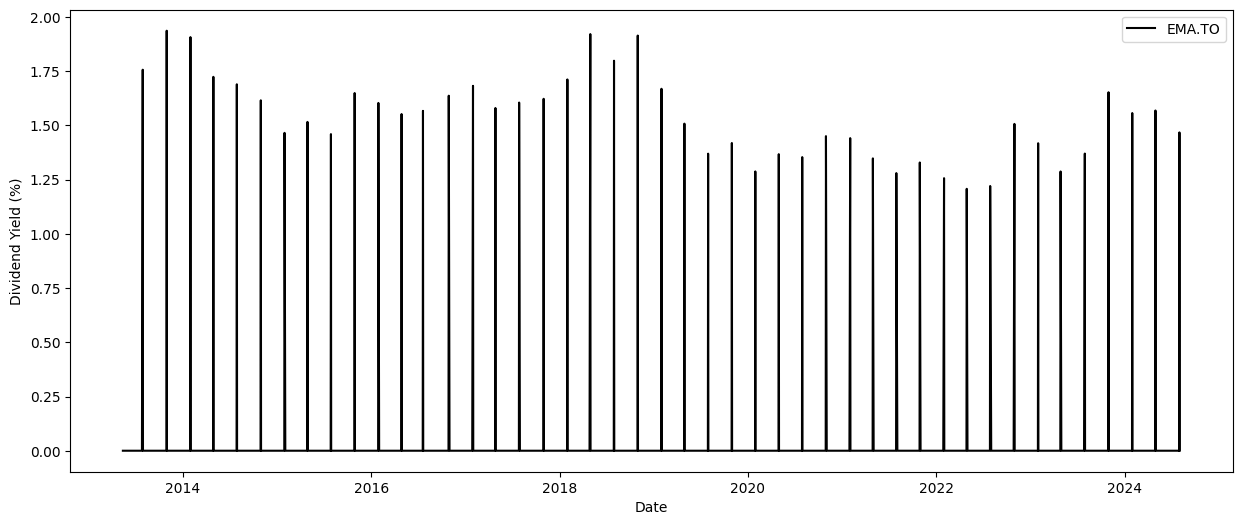

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.609496
share_price      1.000000
Name: share_price, dtype: float64


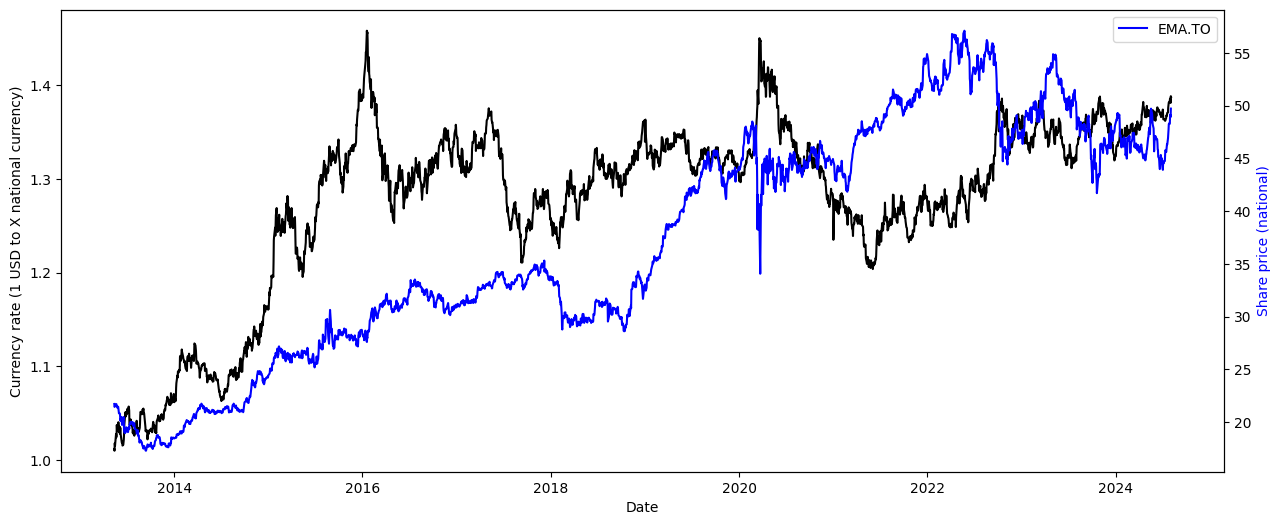

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

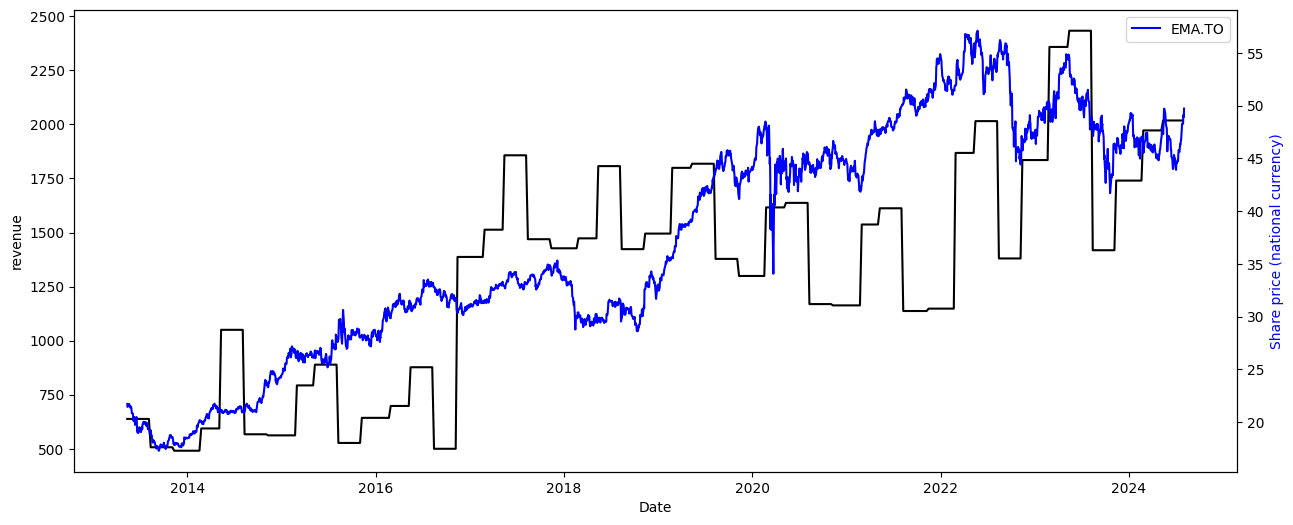

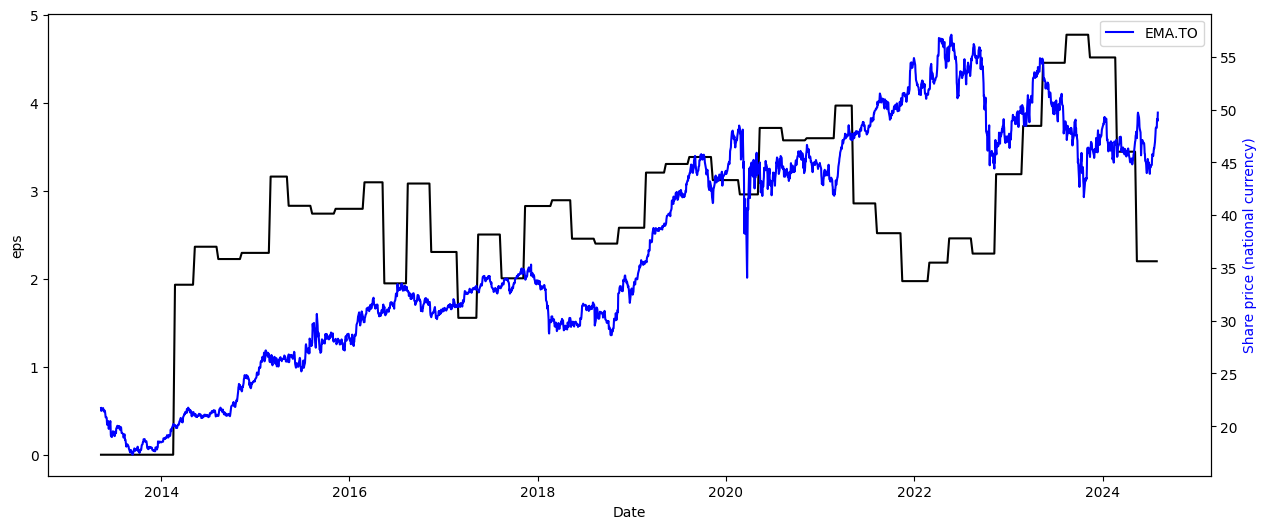

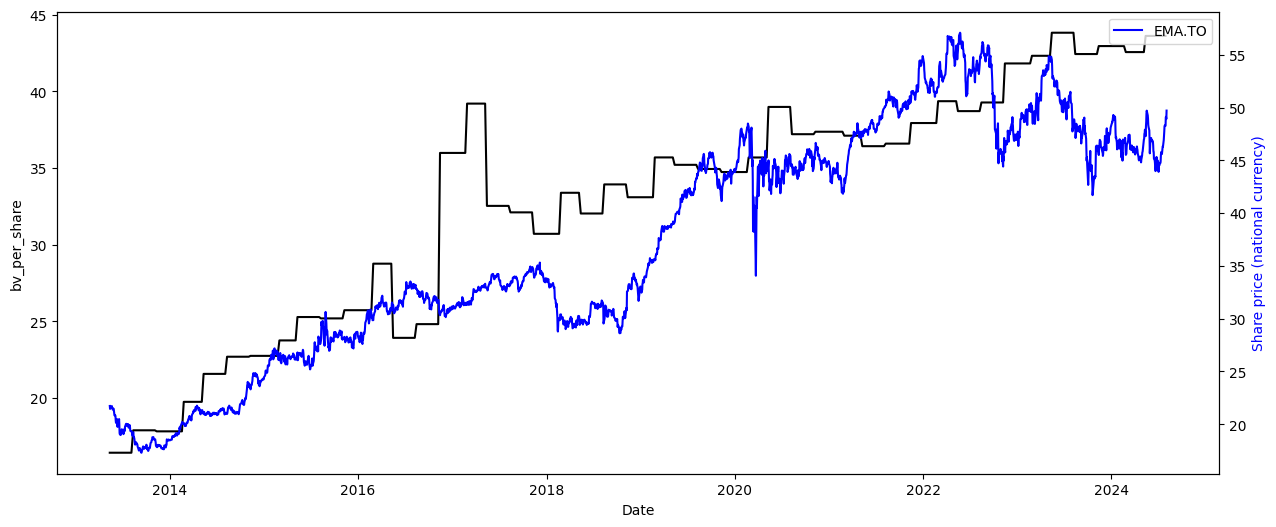

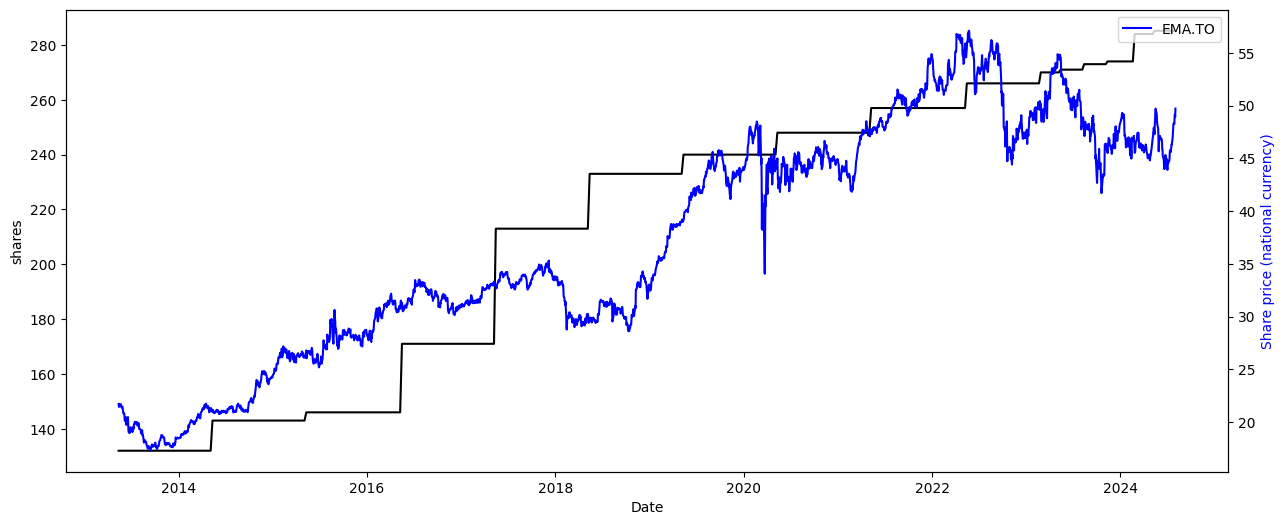

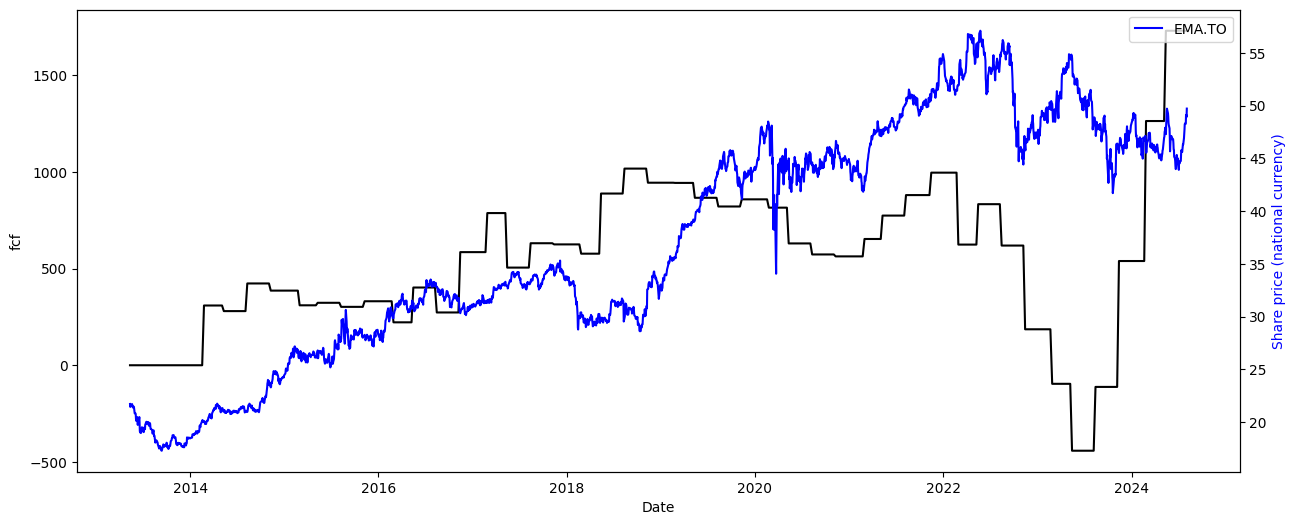

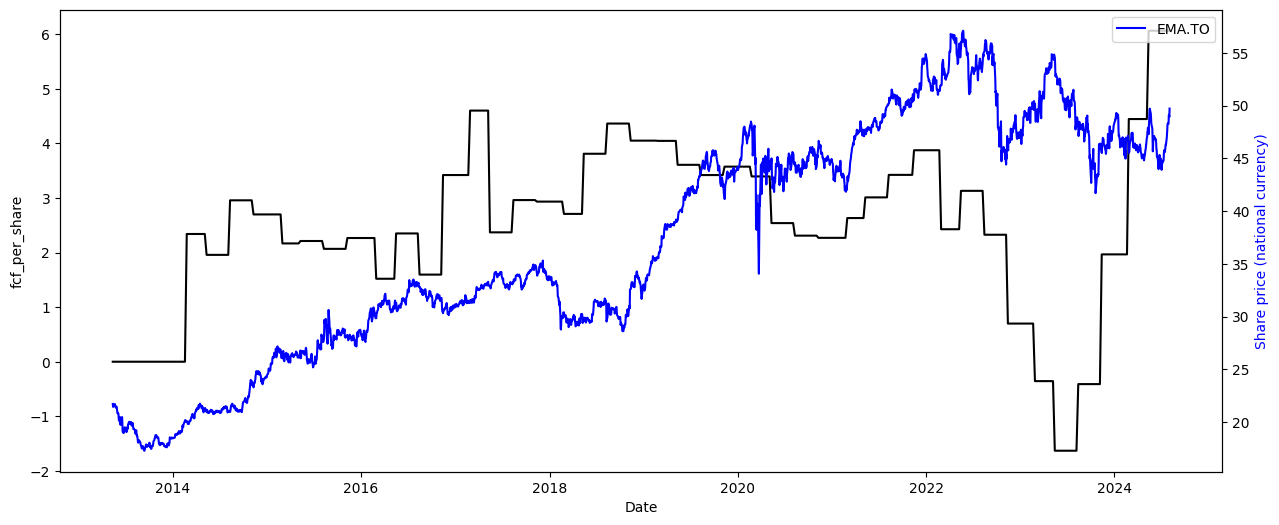

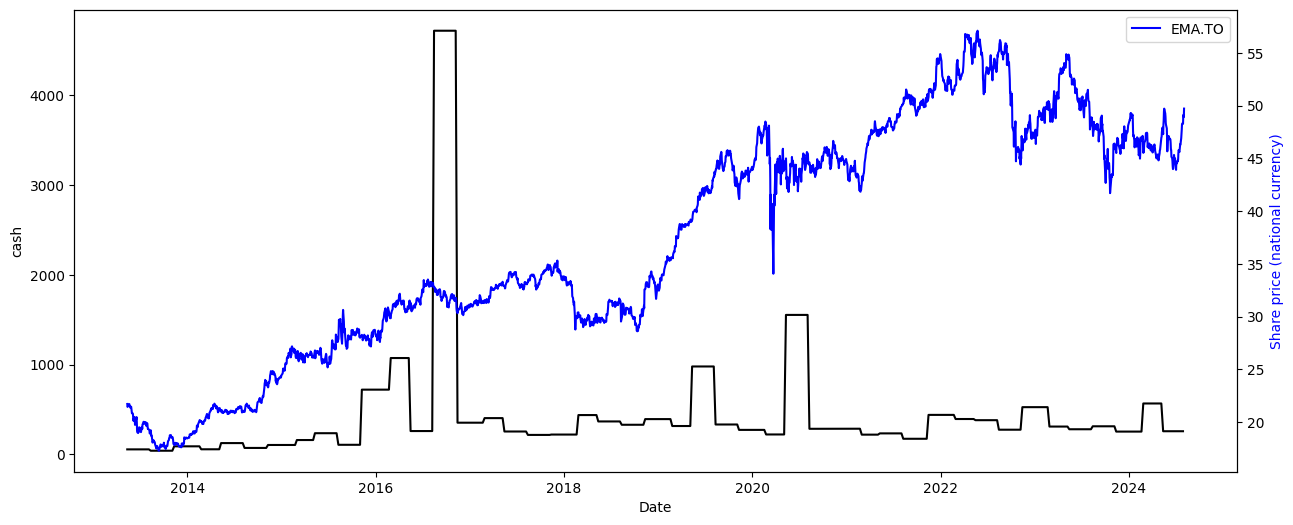

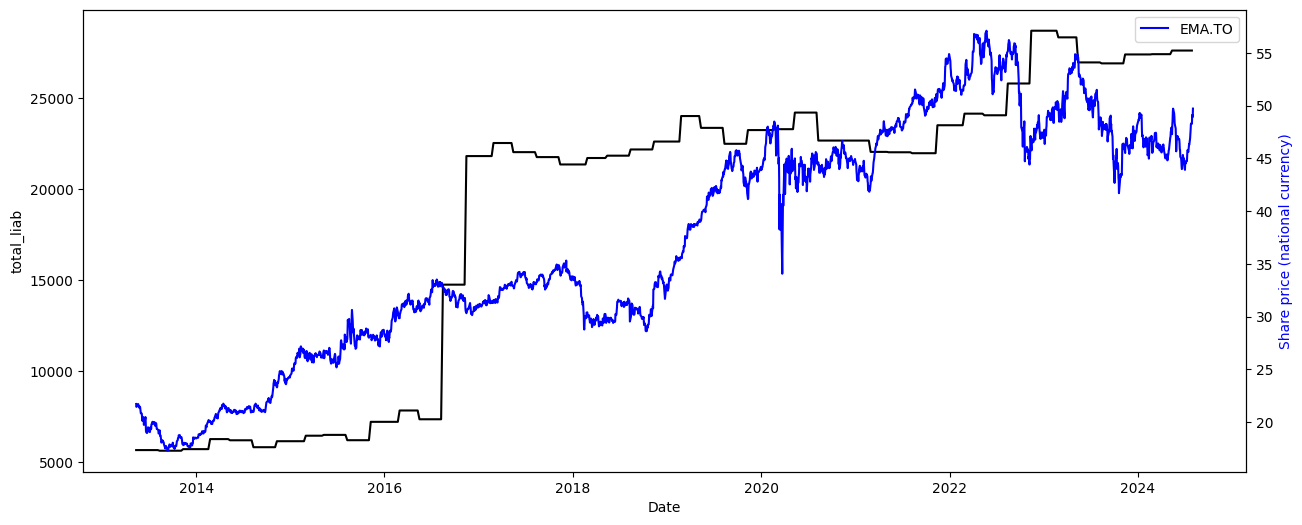

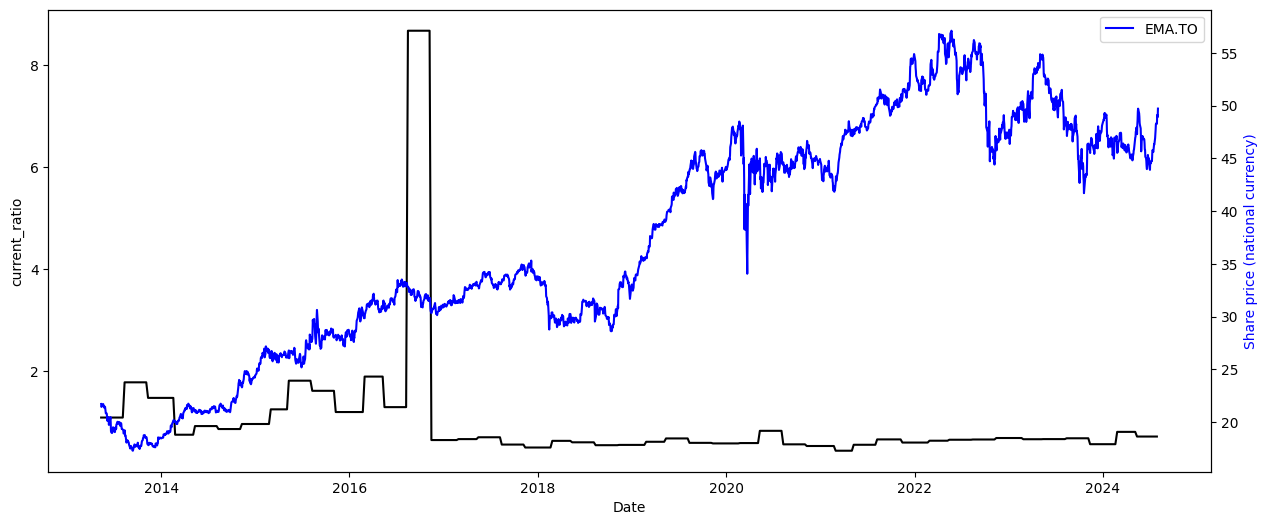

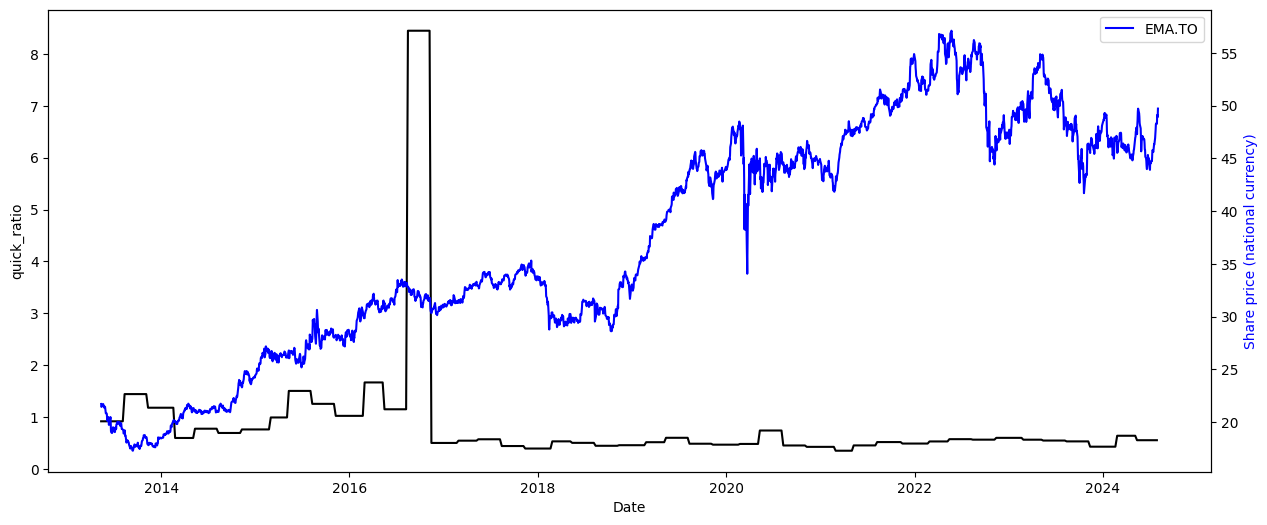

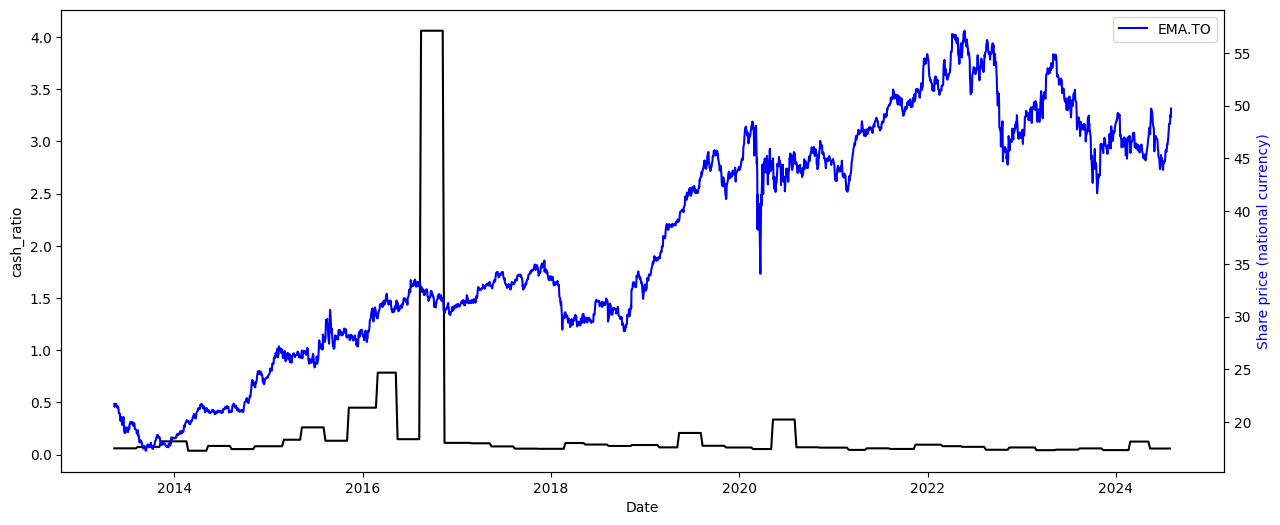

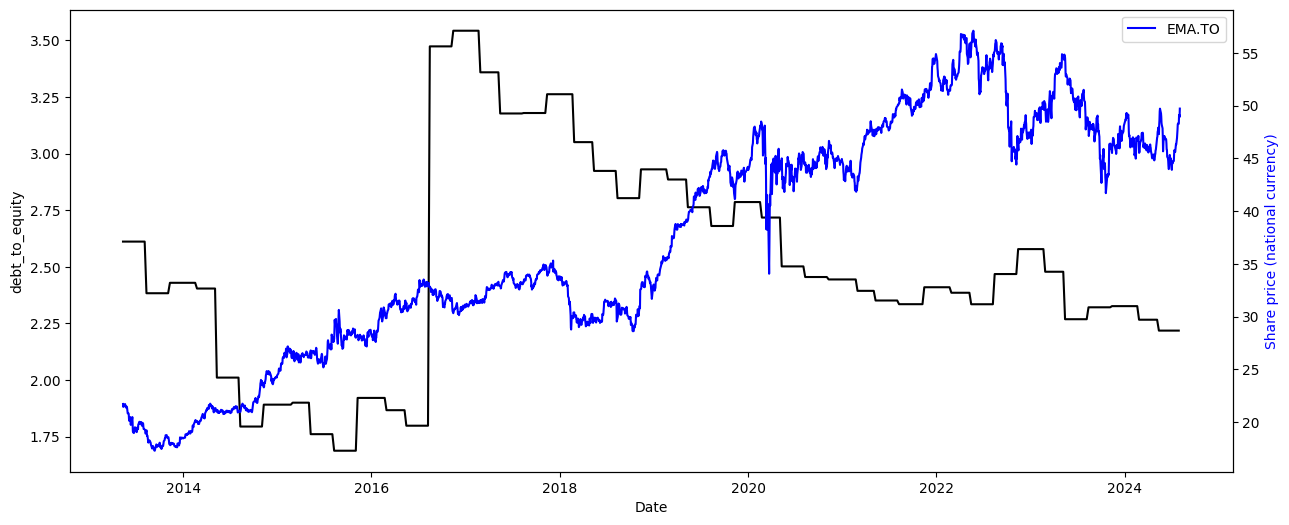

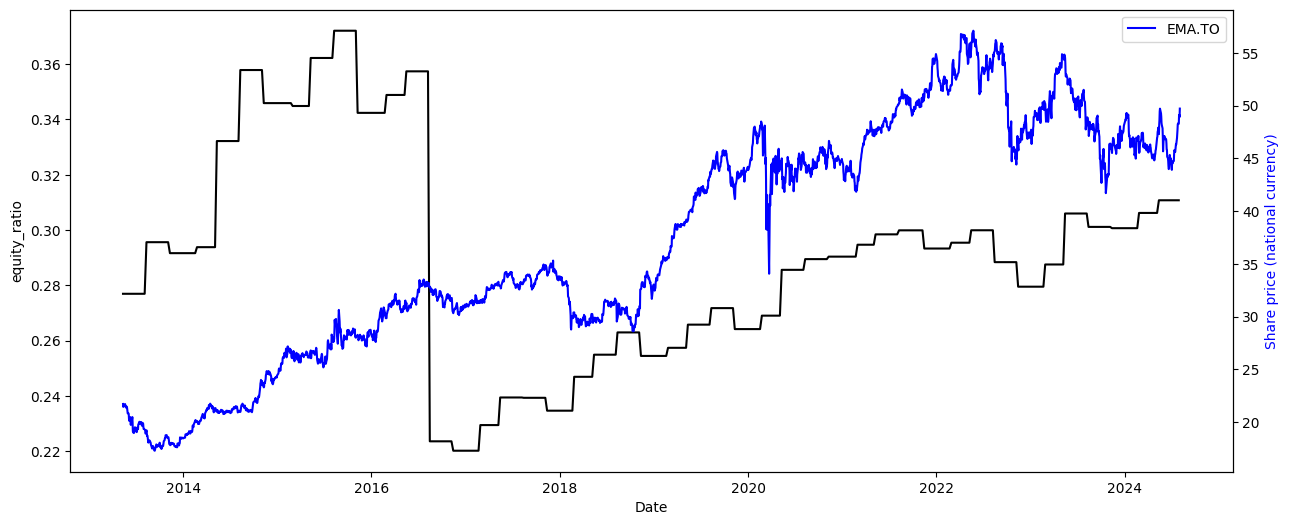

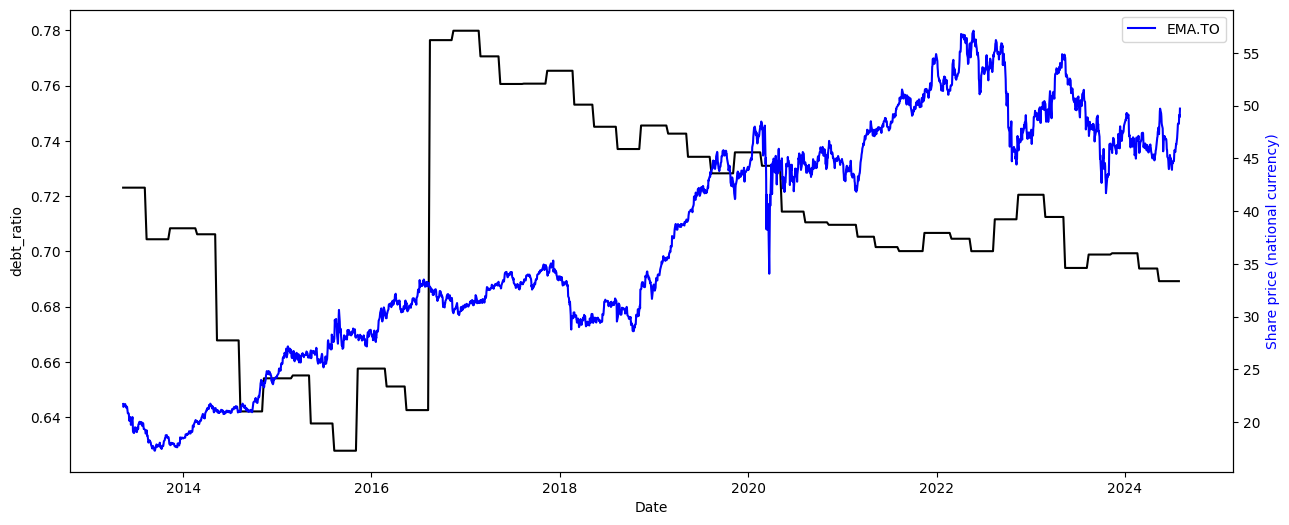

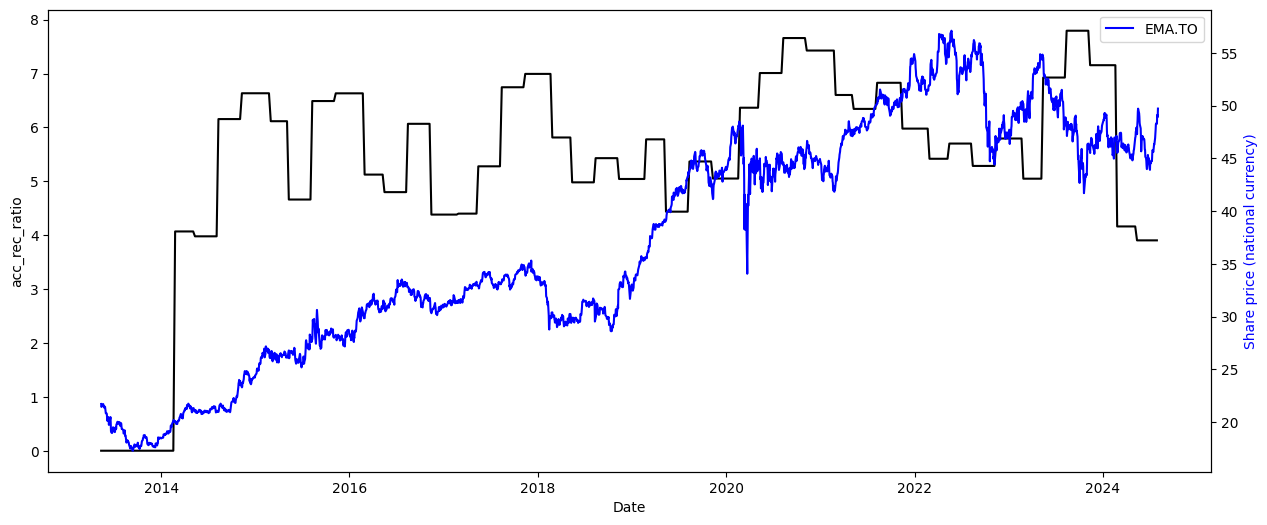

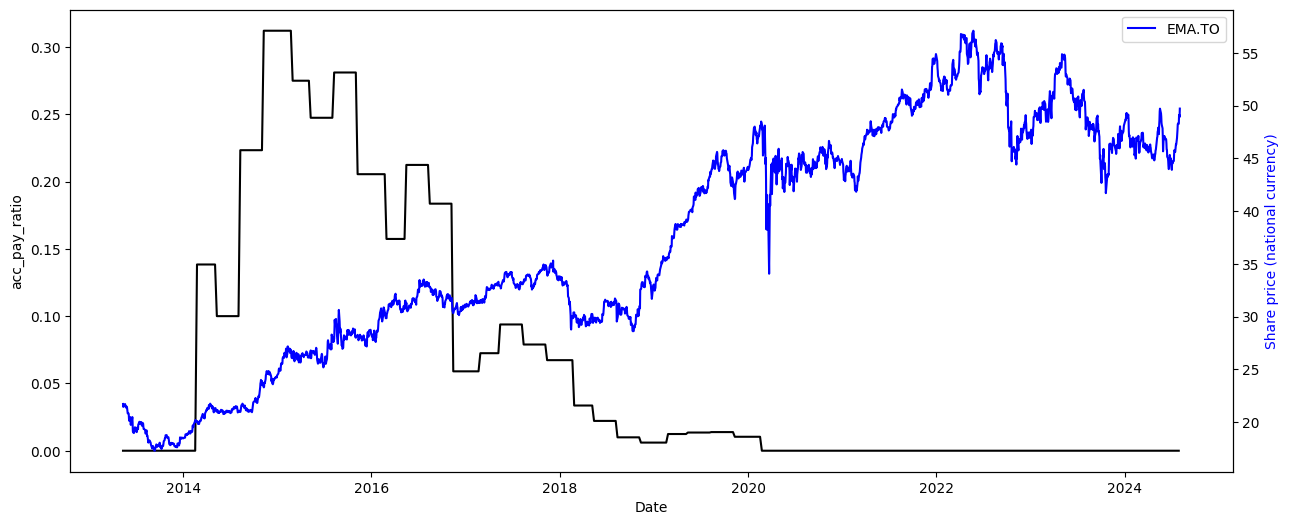

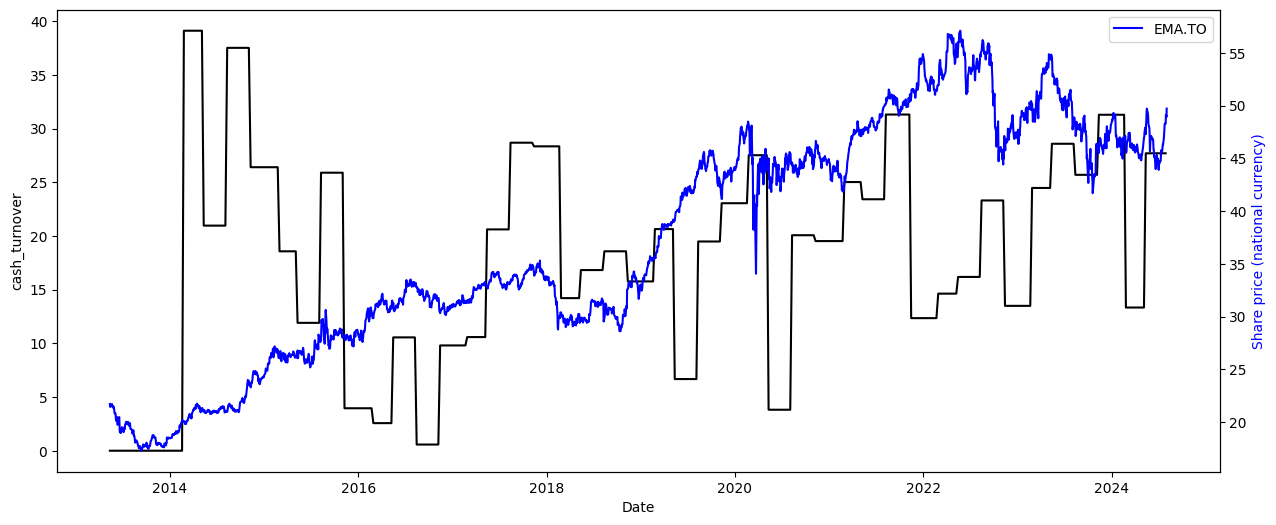

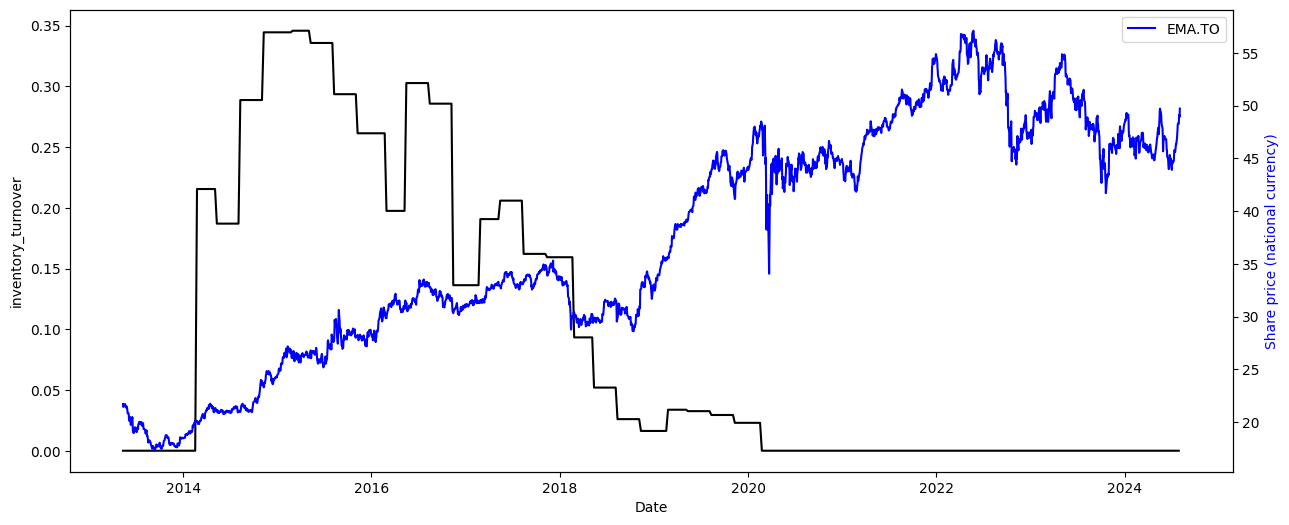

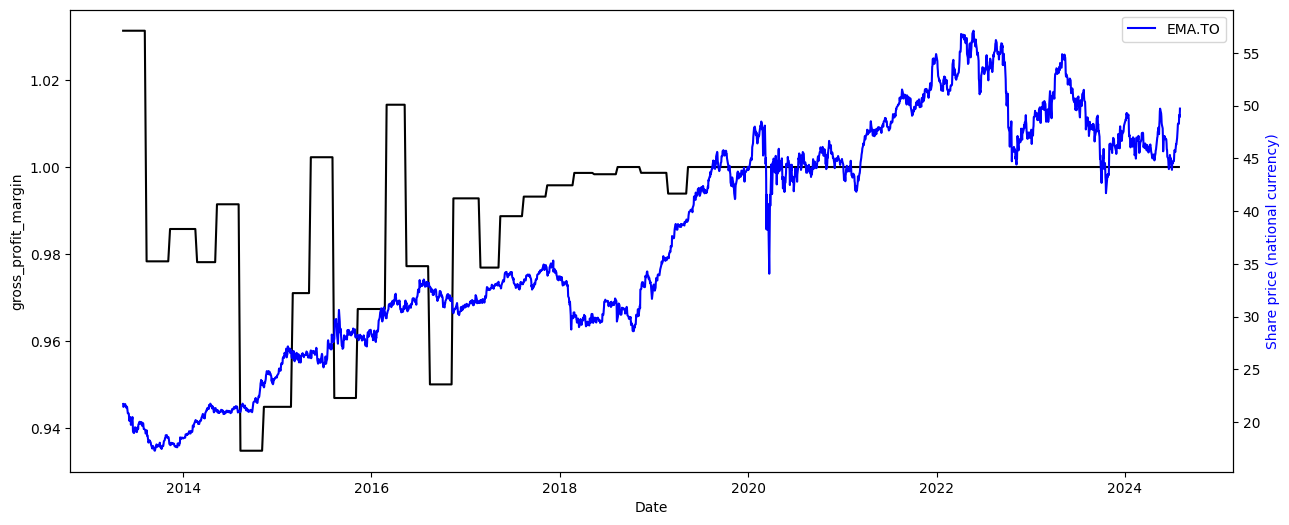

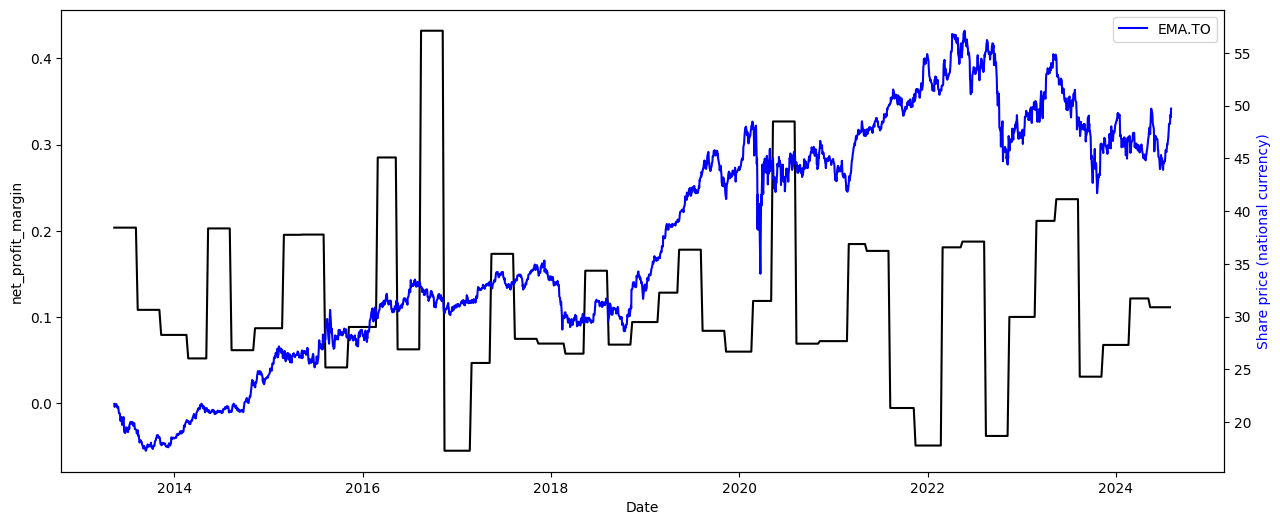

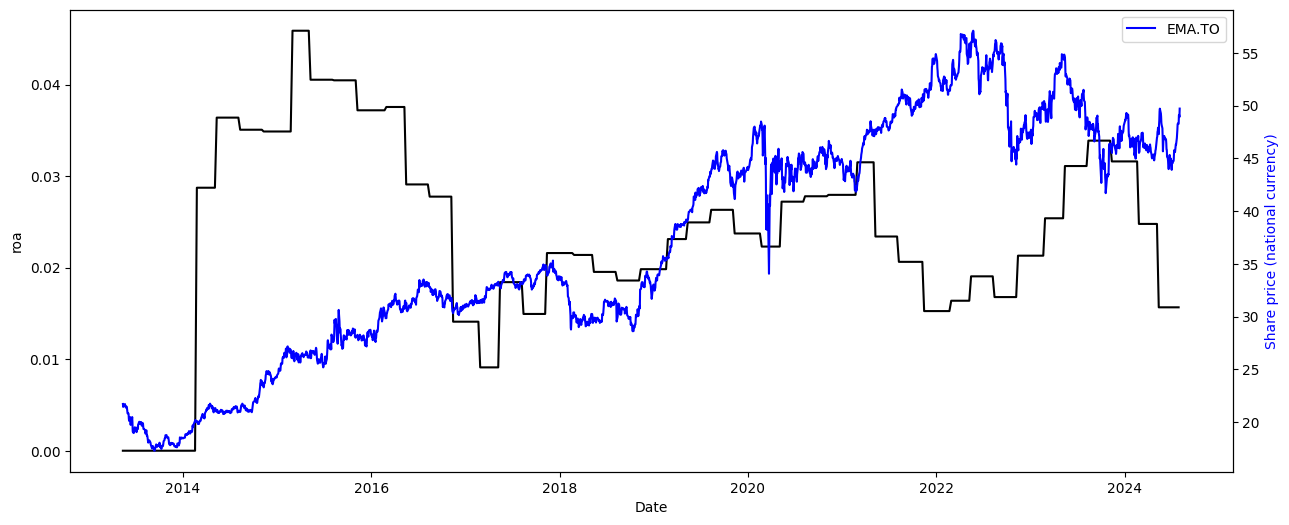

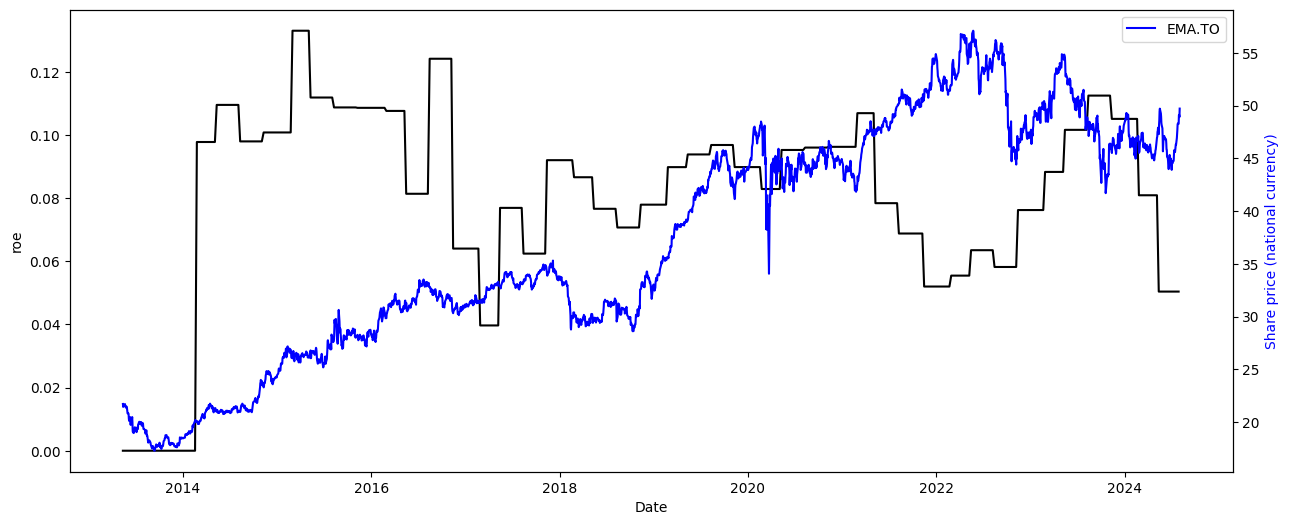

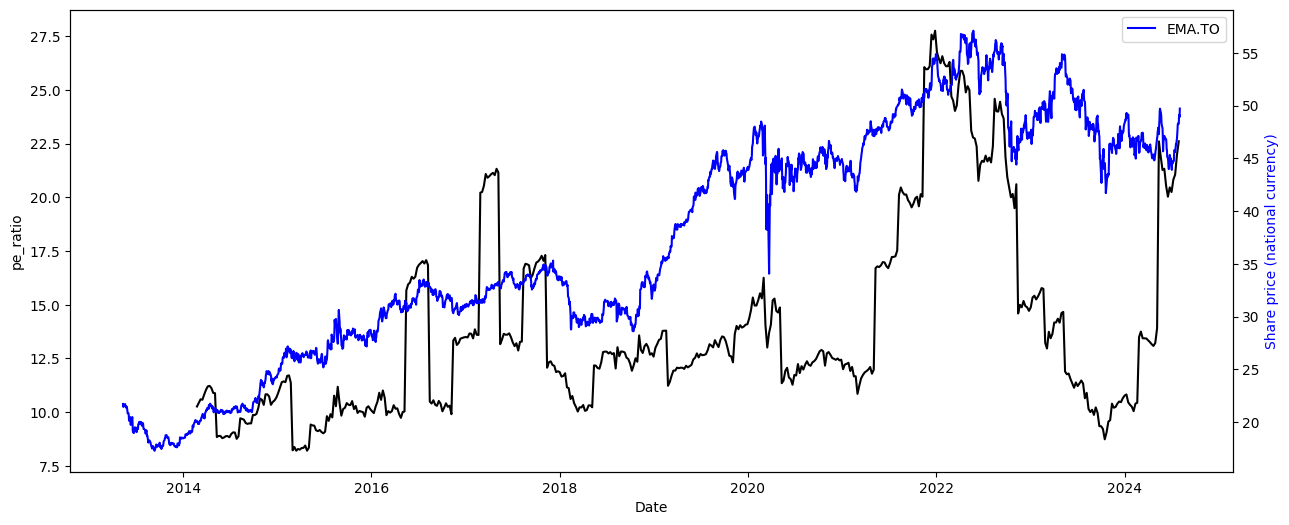

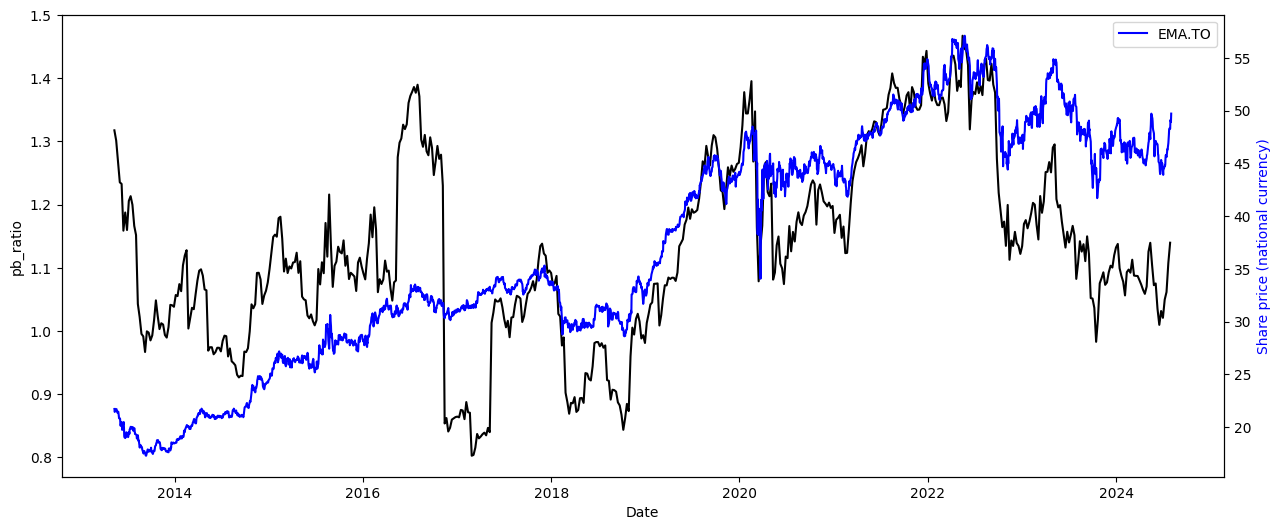

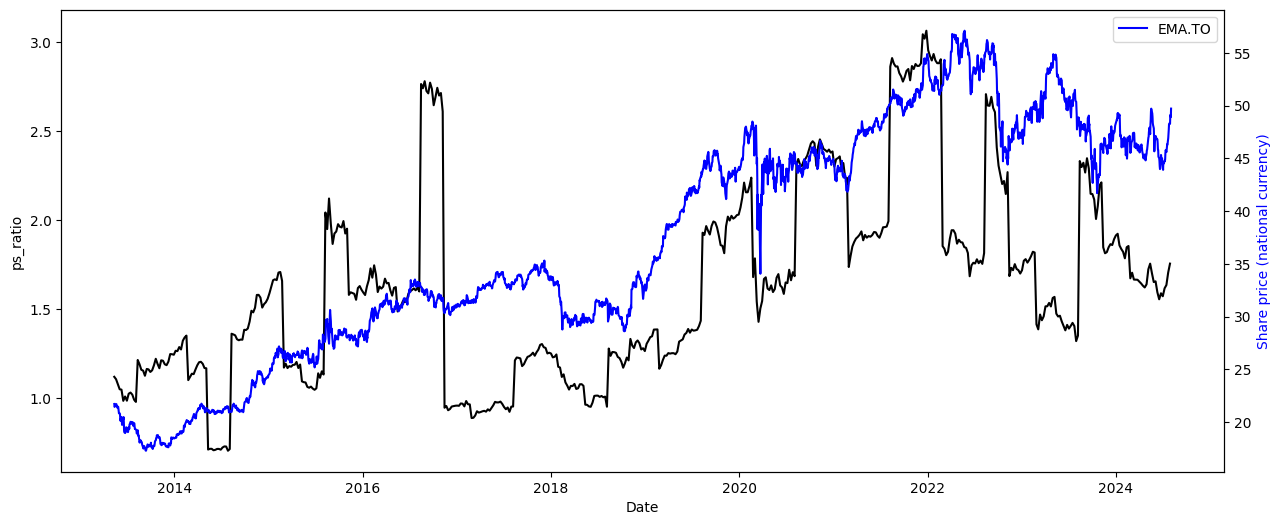

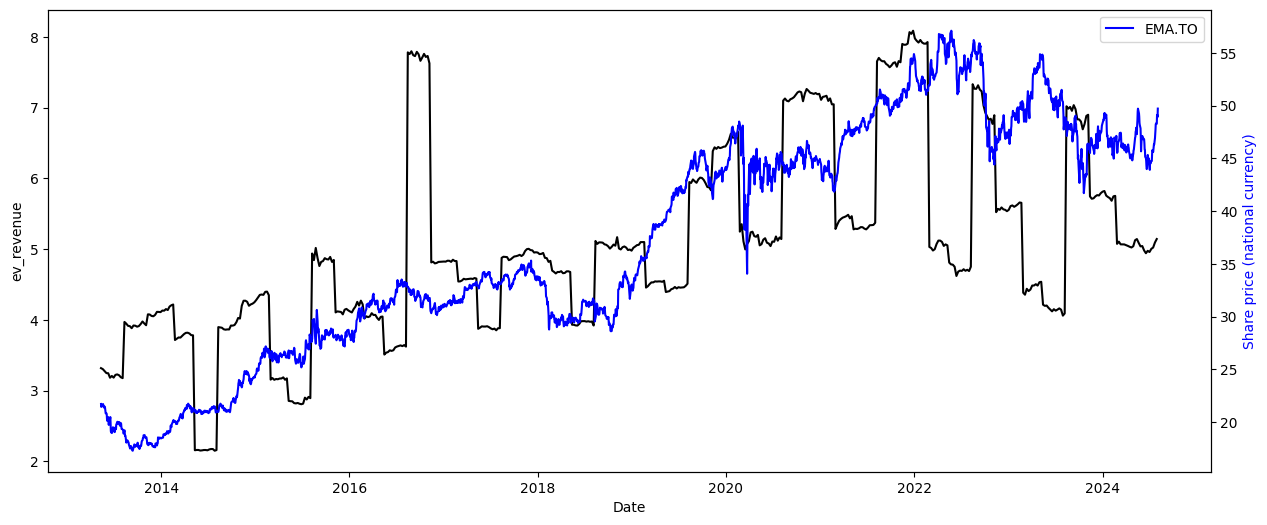

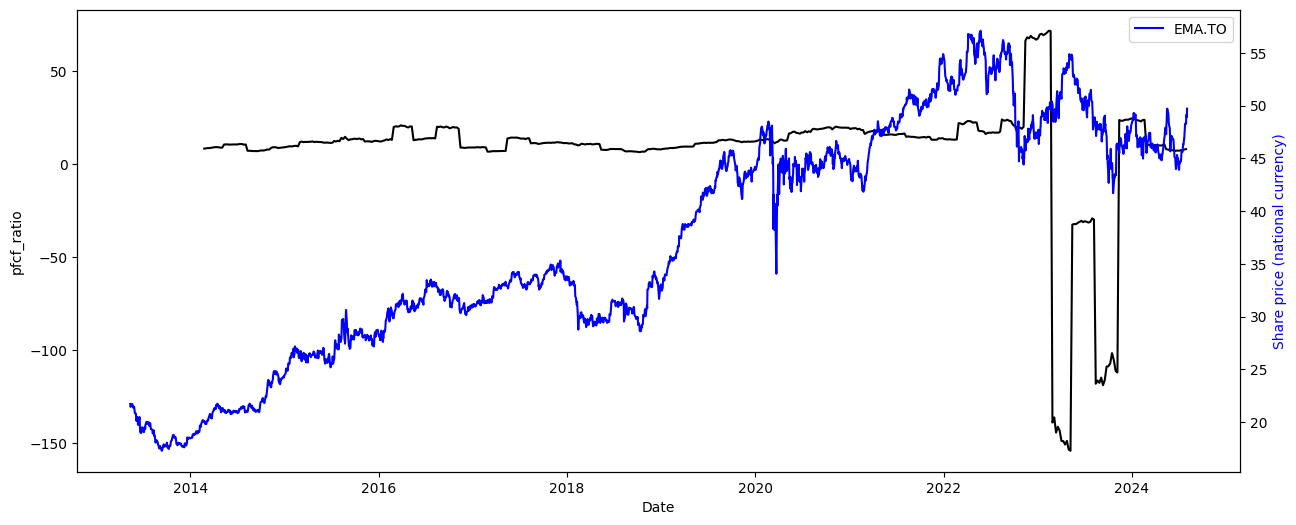

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

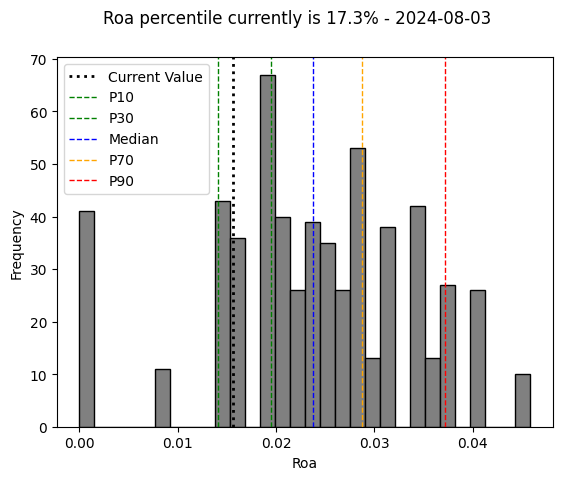

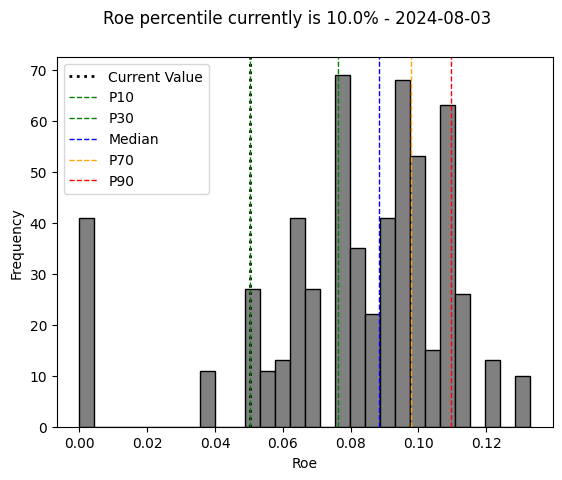

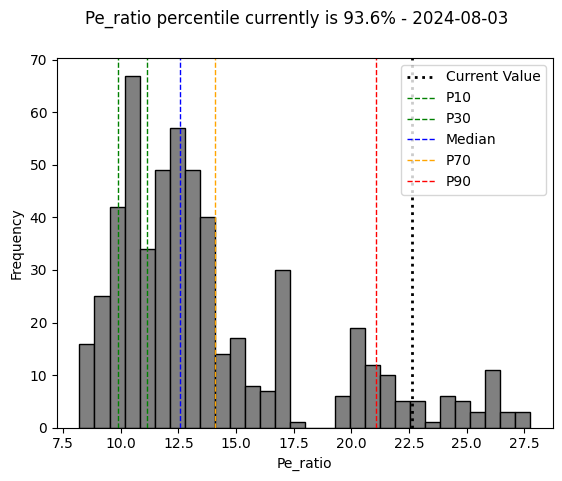

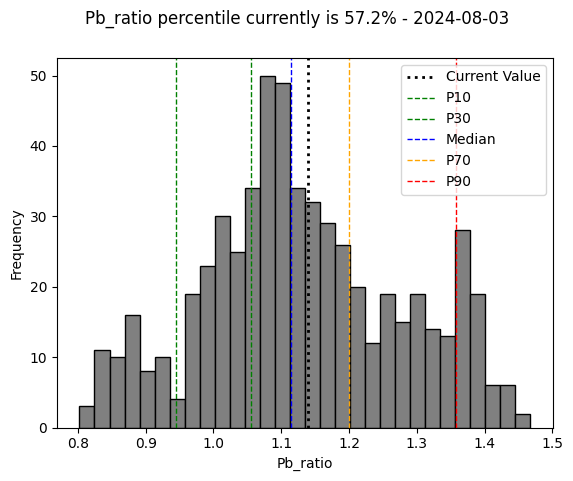

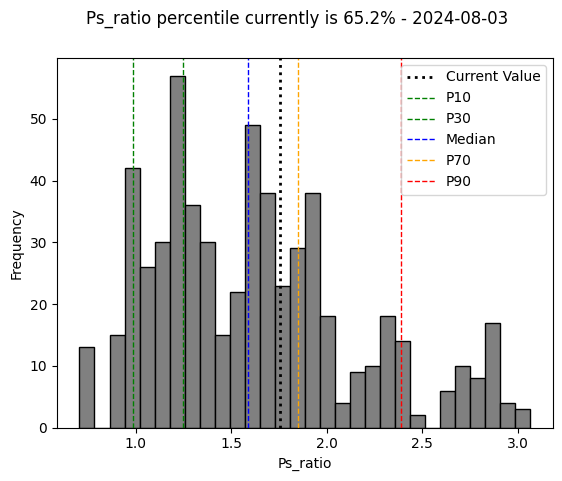

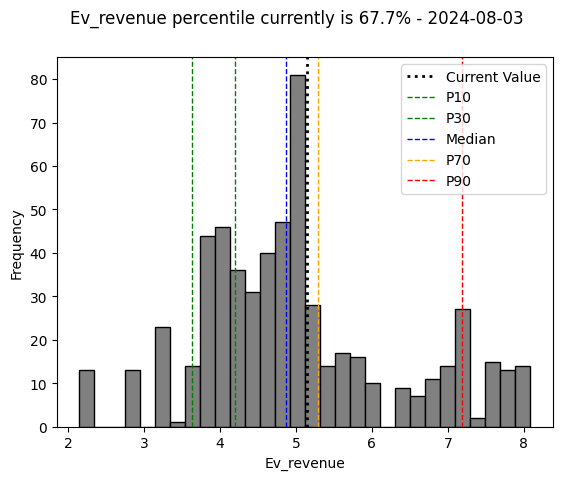

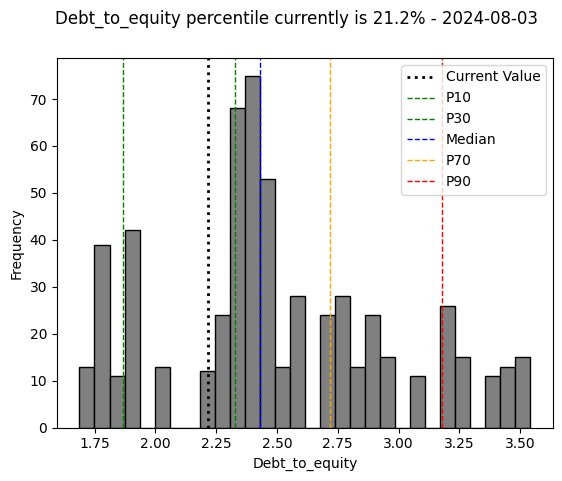

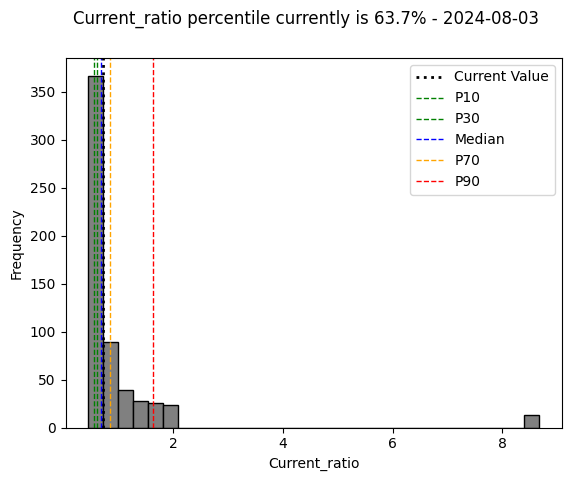

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.937969,-0.710584,0.042727,0.133712,-0.087679,-0.535657,0.095764
roe,0.937969,1.000000,-0.848543,0.027268,0.163196,0.061425,-0.231380,0.176982
pe_ratio,-0.710584,-0.848543,1.000000,0.508982,0.402526,0.401750,0.126344,-0.205344
pb_ratio,0.042727,0.027268,0.508982,1.000000,0.727122,0.475942,-0.236364,0.103710
ps_ratio,0.133712,0.163196,0.402526,0.727122,1.000000,0.885458,-0.154079,0.227053
ev_revenue,-0.087679,0.061425,0.401750,0.475942,0.885458,1.000000,0.255427,0.146469
debt_to_equity,-0.535657,-0.231380,0.126344,-0.236364,-0.154079,0.255427,1.000000,0.132056
current_ratio,0.095764,0.176982,-0.205344,0.103710,0.227053,0.146469,0.132056,1.000000


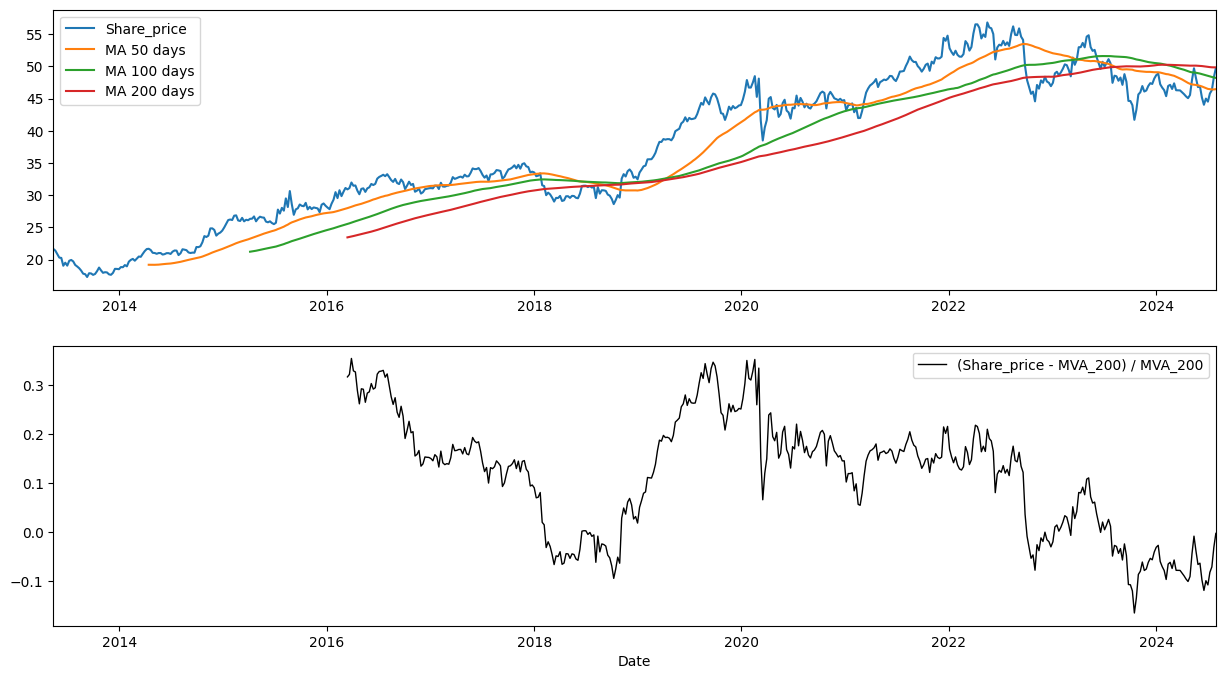

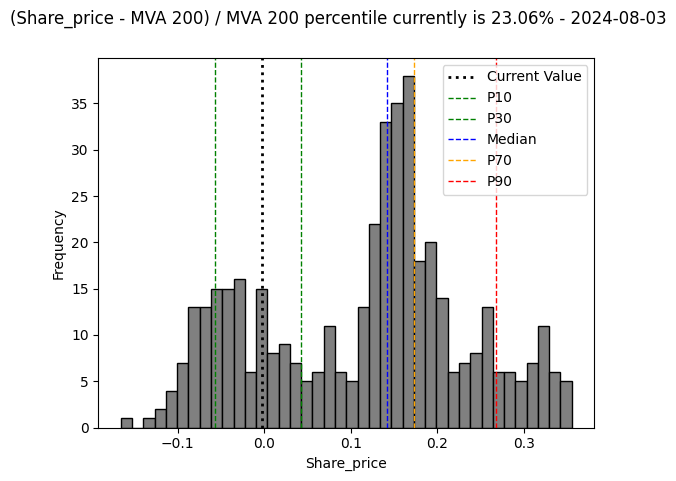

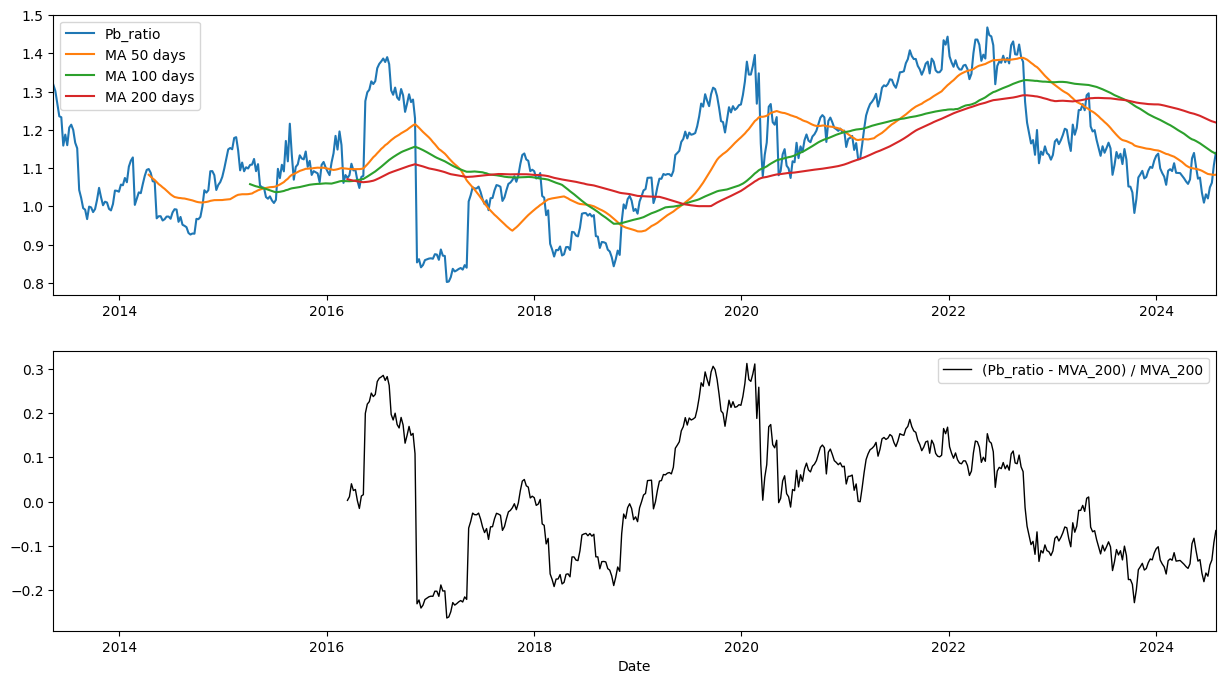

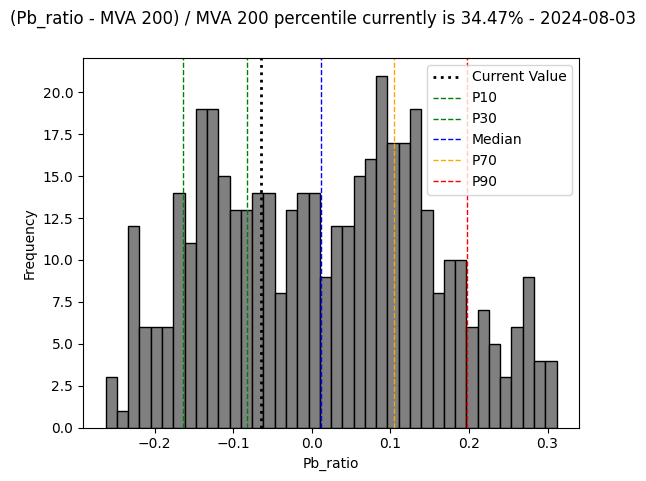

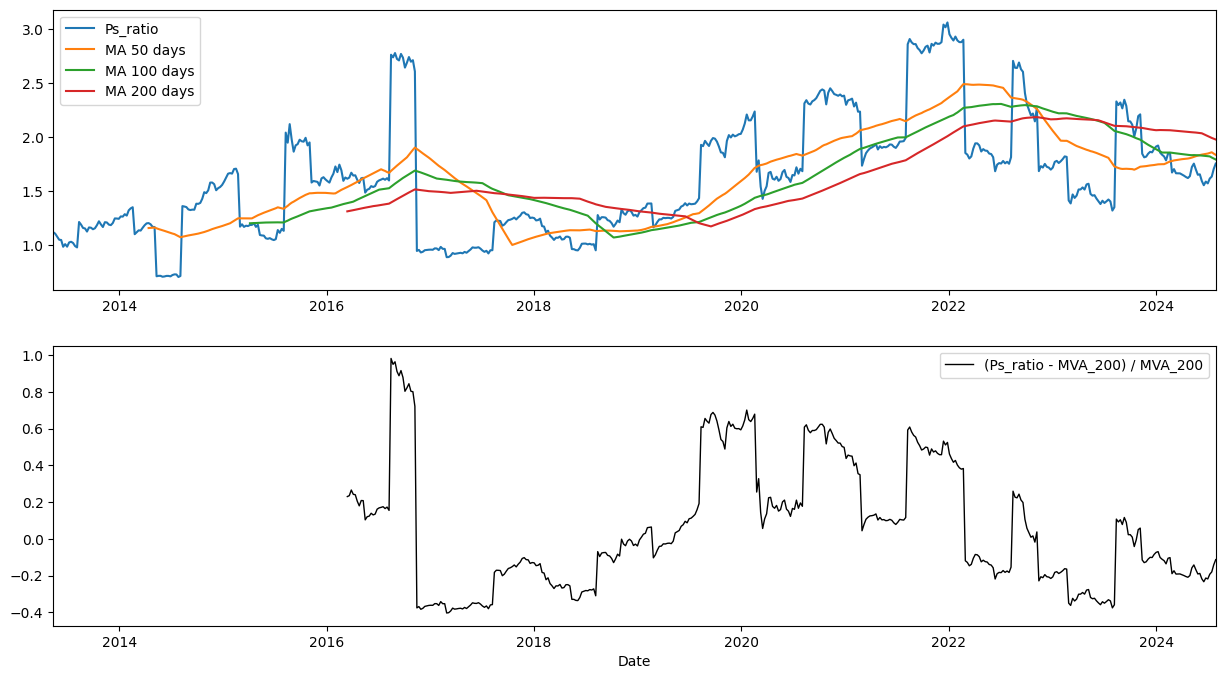

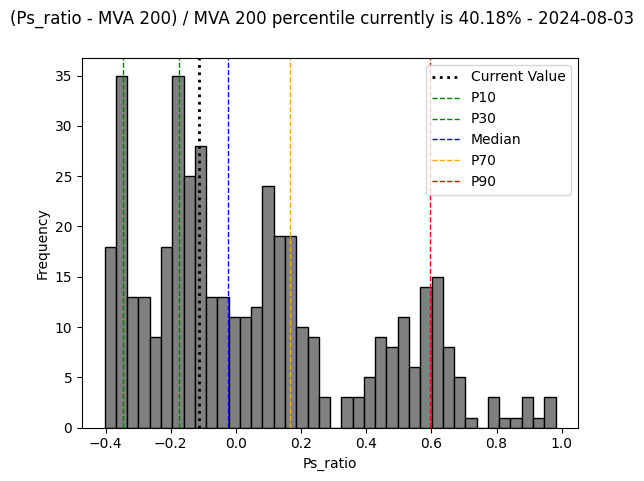

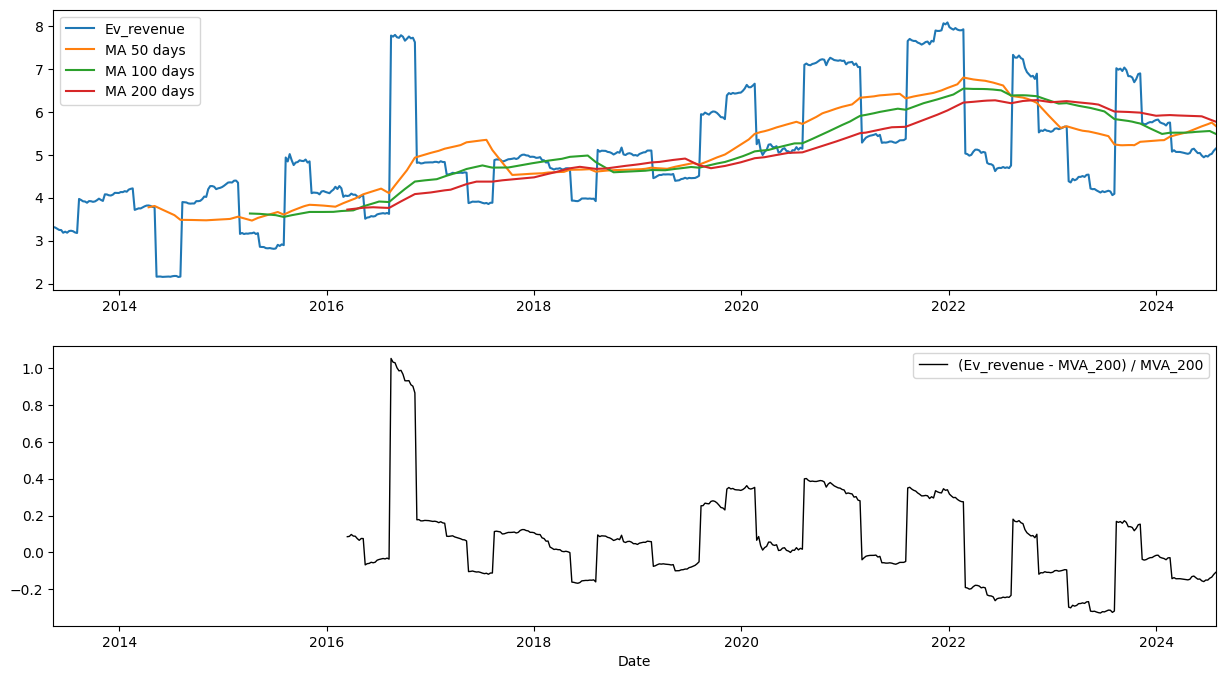

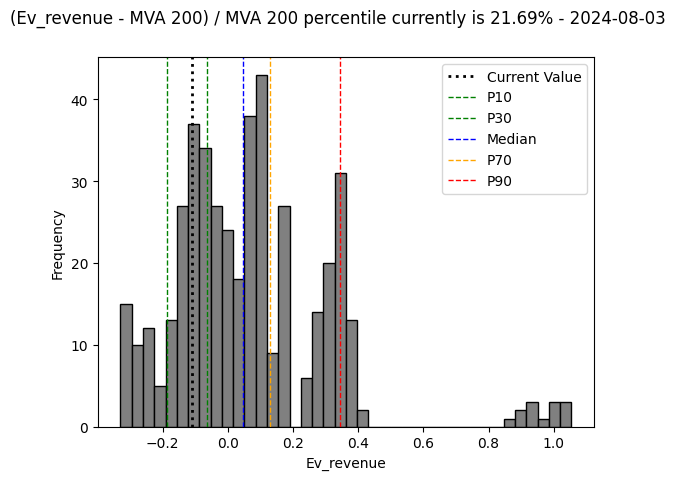

In [21]:
final_df = utils.utility_evaluation(
    input_df=merged_nat_curr,
    owned_shares=owned_shares)